# 01 - EDA YouTube Toxic Comments

En este notebook realizamos el **Análisis Exploratorio de Datos (EDA)** del dataset de comentarios de YouTube etiquetados por toxicidad.

## Objetivos

- Entender la estructura del dataset (filas, columnas, tipos de datos).
- Analizar la distribución de las diferentes etiquetas de toxicidad (multietiqueta).
- Estudiar la longitud y características básicas de los comentarios.
- Detectar posibles problemas: valores nulos, duplicados, desbalanceo de clases.
- Analizar la relación entre tipos de toxicidad.
- Explorar diferencias entre comentarios tóxicos y no tóxicos.
- Obtener insights que nos ayuden a tomar decisiones de preprocesamiento y modelado.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

plt.style.use("ggplot")
sns.set(font_scale=1.1)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)


## 1. Carga de datos

En esta sección:

- Cargamos el CSV que contiene los comentarios de YouTube.
- Comprobamos el número de filas y columnas.
- Visualizamos una muestra de las primeras filas para tener una idea rápida del contenido.


In [3]:
DATA_PATH = "../../data/youtoxic_english_1000.csv"

df = pd.read_csv(DATA_PATH)

print("Tamaño del DataFrame (filas, columnas):", df.shape)
df.head()


Tamaño del DataFrame (filas, columnas): (1000, 15)


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,"If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation. To lump yourself into this mess and take matt...",False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to apprehend. They are trained to shoot to kill. And I thank Wilson for killing that punk bitch.,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' banners being held by white cunts is kinda patronizing and ironically racist. could they have not come up with somethin better.. or is it just what w...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do not like police officers. They are called Criminals and its the reason we have police officers. The fact that Criminals do not like police officers i...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should have not been shot 6 extra time. Shoot him once if hes attacking you and that would stop his attack. Shoot him twice if he's still attacking you, but s...",False,False,False,False,False,False,False,False,False,False,False,False


## 2. Información general del dataset

En esta sección analizamos:

- Tipos de datos de cada columna (`df.info()`).
- Número de valores nulos por columna.
- Número de valores únicos por columna.

Esto nos ayuda a entender la calidad de los datos y posibles problemas iniciales.


In [5]:
print(">>> Info del DataFrame")
print("-" * 80)
df.info()

print("\n>>> Valores nulos por columna")
print("-" * 80)
display(df.isnull().sum())

print("\n>>> Valores únicos por columna")
print("-" * 80)
display(df.nunique())


>>> Info del DataFrame
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64


>>> Valores únicos por columna
--------------------------------------------------------------------------------


CommentId          1000
VideoId              13
Text                997
IsToxic               2
IsAbusive             2
IsThreat              2
IsProvocative         2
IsObscene             2
IsHatespeech          2
IsRacist              2
IsNationalist         2
IsSexist              2
IsHomophobic          1
IsReligiousHate       2
IsRadicalism          1
dtype: int64

## 3. Identificación de tipos de columnas

Clasificamos las columnas en:

- **Identificadores**: columnas que identifican el comentario y el vídeo.
- **Texto**: columna que contiene el comentario en sí.
- **Etiquetas**: columnas binarias que indican diferentes tipos de toxicidad (`Is...`).

Esta separación es útil para el análisis y para el posterior preprocesamiento.


In [6]:
all_columns = df.columns.tolist()

id_cols = ["CommentId", "VideoId"]
text_col = "Text"
label_cols = [c for c in df.columns if c.startswith("Is")]

print("Todas las columnas:", all_columns)
print("\nColumnas ID:", id_cols)
print("Columna de texto:", text_col)
print("Columnas de etiquetas:", label_cols)


Todas las columnas: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

Columnas ID: ['CommentId', 'VideoId']
Columna de texto: Text
Columnas de etiquetas: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']


## 4. Análisis de duplicados

En esta sección buscamos:

- Comentarios con **`CommentId` duplicado**.
- Comentarios con **texto (`Text`) duplicado**.

Los duplicados pueden introducir sesgos en el entrenamiento del modelo, por eso es importante detectarlos desde el EDA.


In [7]:
# Duplicados por CommentId
dup_comment_id = df.duplicated(subset=["CommentId"]).sum()

# Duplicados por texto exacto
dup_text = df.duplicated(subset=["Text"]).sum()

print(f"Número de comentarios con CommentId duplicado: {dup_comment_id}")
print(f"Número de comentarios con texto duplicado: {dup_text}")

if dup_comment_id > 0:
    print("\n>>> Ejemplos de CommentId duplicados")
    display(df[df.duplicated(subset=["CommentId"], keep=False)].head())

if dup_text > 0:
    print("\n>>> Ejemplos de textos duplicados")
    display(df[df.duplicated(subset=["Text"], keep=False)].head())


Número de comentarios con CommentId duplicado: 0
Número de comentarios con texto duplicado: 3

>>> Ejemplos de textos duplicados


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
592,UgiXm5jxvkdIxHgCoAEC,cT14IbTDW2c,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False
642,Ugxen2QgJYhNiRrMegR4AaABAg,cT14IbTDW2c,run them over,True,True,True,False,False,False,False,False,False,False,False,False
657,UgxXtUmfp0rdwXB8qld4AaABAg,cT14IbTDW2c,run them over,True,True,False,True,False,False,False,False,False,False,False,False
677,UgyjhPsMlWKlFNmG-h94AaABAg,cT14IbTDW2c,run them over,True,True,False,True,False,False,False,False,False,False,False,False
699,UgzFZGnqcjZcW7wejI54AaABAg,cT14IbTDW2c,RUN THEM OVER,True,True,False,True,False,False,False,False,False,False,False,False


## 5. Análisis descriptivo de las etiquetas de toxicidad

Las columnas que empiezan por `Is` son etiquetas binarias que indican diferentes tipos de toxicidad 
(por ejemplo, `IsToxic`, `IsAbusive`, `IsHatespeech`, etc.).

En esta sección:

- Contamos cuántos comentarios positivos (1/True) hay por cada etiqueta.
- Calculamos el porcentaje sobre el total de comentarios.
- Visualizamos la distribución de las etiquetas con un gráfico de barras.


Distribución de las etiquetas de toxicidad:


,count_true,perc_true
IsToxic,462,46.2
IsAbusive,353,35.3
IsProvocative,161,16.1
IsHatespeech,138,13.8
IsRacist,125,12.5
IsObscene,100,10.0
IsThreat,21,2.1
IsReligiousHate,12,1.2
IsNationalist,8,0.8
IsSexist,1,0.1


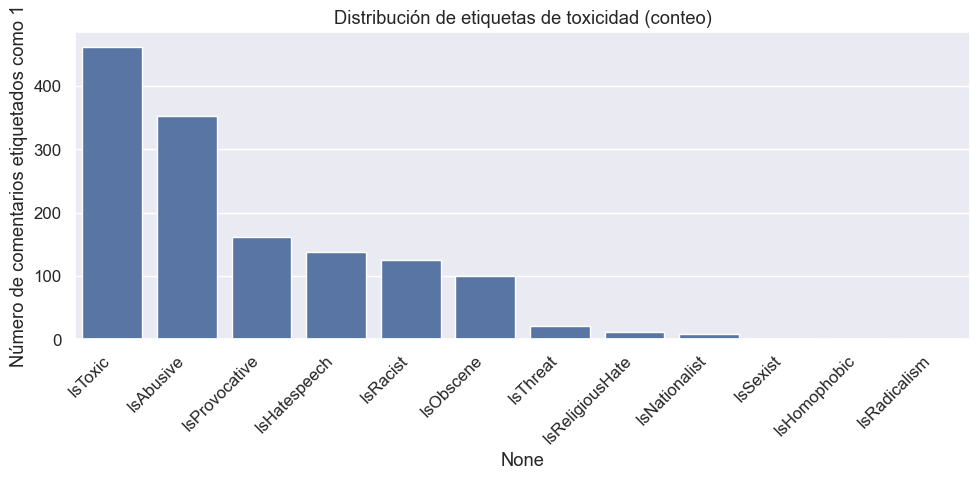

In [8]:
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_perc = (label_counts / len(df) * 100).round(2)

label_summary = pd.DataFrame({
    "count_true": label_counts,
    "perc_true": label_perc
})

print("Distribución de las etiquetas de toxicidad:")
display(label_summary)

plt.figure(figsize=(10, 5))
sns.barplot(x=label_summary.index, y=label_summary["count_true"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Número de comentarios etiquetados como 1")
plt.title("Distribución de etiquetas de toxicidad (conteo)")
plt.tight_layout()
plt.show()


## 6. Etiqueta agregada: `IsAnyToxic`

Aunque el problema es multietiqueta, muchas veces es útil disponer de una etiqueta binaria:

- **`IsAnyToxic` = 1** si el comentario tiene al menos una etiqueta de toxicidad positiva.
- **`IsAnyToxic` = 0** en caso contrario.

Esto nos permitirá:

- Analizar la proporción global de comentarios tóxicos vs no tóxicos.
- Comparar propiedades de texto entre ambos grupos.


Distribución de IsAnyToxic (0 = no tóxico, 1 = tóxico):


,count,perc
IsAnyToxic,,
0,538,53.8
1,462,46.2


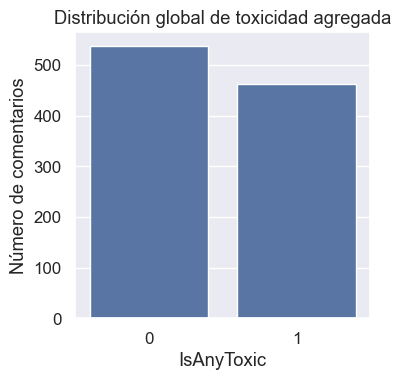

In [9]:
df["IsAnyToxic"] = df[label_cols].any(axis=1).astype(int)

any_toxic_counts = df["IsAnyToxic"].value_counts().sort_index()
any_toxic_perc = (any_toxic_counts / len(df) * 100).round(2)

print("Distribución de IsAnyToxic (0 = no tóxico, 1 = tóxico):")
display(pd.DataFrame({"count": any_toxic_counts, "perc": any_toxic_perc}))

plt.figure(figsize=(4, 4))
sns.barplot(x=any_toxic_counts.index.astype(str), y=any_toxic_counts.values)
plt.xlabel("IsAnyToxic")
plt.ylabel("Número de comentarios")
plt.title("Distribución global de toxicidad agregada")
plt.tight_layout()
plt.show()


## 7. Estructura multietiqueta

Un mismo comentario puede tener varias etiquetas de toxicidad activas a la vez.

En esta sección:

- Calculamos cuántas etiquetas positivas tiene cada comentario (`num_labels_true`).
- Analizamos la distribución de ese número.
- Observamos las combinaciones de etiquetas más frecuentes.


Distribución del número de etiquetas positivas por comentario:


num_labels_true
0    538
2    100
3    294
4     47
5     15
6      6
Name: count, dtype: int64

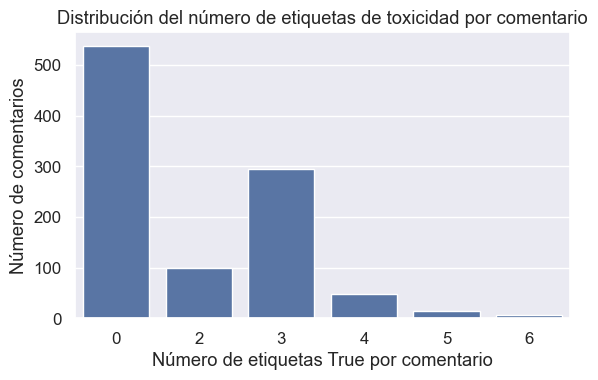

In [10]:
df["num_labels_true"] = df[label_cols].sum(axis=1)

num_labels_counts = df["num_labels_true"].value_counts().sort_index()
print("Distribución del número de etiquetas positivas por comentario:")
display(num_labels_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=num_labels_counts.index, y=num_labels_counts.values)
plt.xlabel("Número de etiquetas True por comentario")
plt.ylabel("Número de comentarios")
plt.title("Distribución del número de etiquetas de toxicidad por comentario")
plt.tight_layout()
plt.show()


In [11]:
# Representamos el patrón de etiquetas como una cadena "010101..."
label_pattern_series = df[label_cols].astype(int).astype(str).agg("".join, axis=1)
pattern_counts = label_pattern_series.value_counts()

print("Número de combinaciones distintas de etiquetas:", pattern_counts.shape[0])

print("\nTop 10 combinaciones de etiquetas más frecuentes (como patrón binario):")
display(pattern_counts.head(10))


Número de combinaciones distintas de etiquetas: 21

Top 10 combinaciones de etiquetas más frecuentes (como patrón binario):


000000000000    538
110100000000    118
110000000000     99
100001100000     91
110010000000     66
110110000000     23
111000000000     11
100001000010      8
110101100000      7
100001110000      7
Name: count, dtype: int64

## 8. Correlación entre etiquetas de toxicidad

Queremos saber si ciertas formas de toxicidad suelen aparecer juntas.

En esta sección:

- Calculamos la matriz de correlación de Pearson entre las columnas de etiquetas.
- Visualizamos la matriz con un heatmap para identificar relaciones fuertes (positivas o negativas).


In [ ]:
corr_matrix = df[label_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación entre etiquetas de toxicidad")
plt.tight_layout()
plt.show()
